In [60]:
import pandas as pd 
import os 
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plots
markers = ['o', 's', 'D', 'v', 'p', 'P', 'X', 'h', 'H', 'd']
colors_discrete = sns.color_palette('tab10')
colors_continuous = sns.color_palette('viridis')


# Do not hide any columns
pd.set_option('display.max_columns', None)


# Read all the results from results/ directory
results = []
for file in os.listdir('results'):
    if file.endswith('.feather'):
        results.append(pd.read_feather(f'results/{file}'))

# Concatenate all the results
df: pd.DataFrame = pd.concat(results, ignore_index=True)

df.head(5)

,experiment_type,dataset_name,k_mlps_in_B,fold_i,experiment_generalization_type,beta_confidence,delta_robustness,model2_name,x_test_sample,y_test_sample,model1_pred_proba,model1_pred_crisp,model2_pred_proba,model2_pred_crisp,base_counterfactual,base_counterfactual_model1_pred_proba,base_counterfactual_model1_pred_crisp,base_counterfactual_model2_pred_proba,base_counterfactual_model2_pred_crisp,base_counterfactual_validity,base_counterfactual_proximityL1,base_counterfactual_proximityL2,base_counterfactual_plausibility,base_counterfactual_discriminative_power,base_counterfactual_validity_model2,base_counterfactual_time,robust_counterfactual,robust_counterfactual_model1_pred_proba,robust_counterfactual_model1_pred_crisp,robust_counterfactual_model2_pred_proba,robust_counterfactual_model2_pred_crisp,robust_counterfactual_validity,robust_counterfactual_proximityL1,robust_counterfactual_proximityL2,robust_counterfactual_plausibility,robust_counterfactual_discriminative_power,robust_counterfactual_validity_model2,robust_counterfactual_L1_distance_from_base_cf,robust_counterfactual_L2_distance_from_base_cf,robust_counterfactual_time,start_sample_passes_test,counterfactual_does_not_pass_test,counterfactual_does_not_have_target_class,counterfactual_is_nan,highest_delta
0,Bootstrap-Architecture,fico,32,0,Bootstrap-Architecture,0.8,0.5,Model2_0,"[0.423076923076923, 0.19897084048027444, 0.169...",0,0.134287,0,0.147861,0,"[0.7545202377021992, 0.030409299805246953, 0.2...",0.51012,1.0,0.601298,1.0,1.0,2.940069,0.73164,0.66634,0.666667,1.0,0.021767,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bootstrap-Architecture,fico,32,0,Bootstrap-Architecture,0.8,0.5,Model2_0,"[0.423076923076923, 0.19897084048027444, 0.169...",0,0.134287,0,0.147861,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.7508948551947412, 0.03727385012071058, 0.23...",0.530759,1.0,0.613003,1.0,1.0,2.952354,0.735085,0.663830,0.666667,1.0,0.097824,0.000624,23.589093,0.0,0.0,0.0,0.0,0.512019
2,Bootstrap-Architecture,fico,32,0,Bootstrap-Architecture,0.8,0.5,Model2_1,"[0.423076923076923, 0.19897084048027444, 0.169...",0,0.134287,0,0.125619,0,"[0.7545202377021992, 0.030409299805246953, 0.2...",0.51012,1.0,0.444571,0.0,1.0,2.940069,0.73164,0.66634,0.666667,0.0,0.021767,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bootstrap-Architecture,fico,32,0,Bootstrap-Architecture,0.8,0.5,Model2_1,"[0.423076923076923, 0.19897084048027444, 0.169...",0,0.134287,0,0.125619,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.7595146793183168, 0.03351878766569367, 0.23...",0.529004,1.0,0.454427,0.0,1.0,2.967001,0.739852,0.669554,0.666667,0.0,0.076563,0.000429,1.801428,0.0,0.0,0.0,0.0,0.512019
4,Bootstrap-Architecture,fico,32,0,Bootstrap-Architecture,0.8,0.5,Model2_2,"[0.423076923076923, 0.19897084048027444, 0.169...",0,0.134287,0,0.104445,0,"[0.7545202377021992, 0.030409299805246953, 0.2...",0.51012,1.0,0.562796,1.0,1.0,2.940069,0.73164,0.66634,0.666667,1.0,0.021767,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
df['start_sample_passes_test'].value_counts()

0.0    281
Name: start_sample_passes_test, dtype: int64

In [62]:
base_validity_model2 = df[df['base_counterfactual'] != None]['base_counterfactual_validity_model2'].dropna()
print('Average base_counterfactual_validity_model2:', base_validity_model2.mean())

robust_validity_model2 = df[df['robust_counterfactual'] != None]['robust_counterfactual_validity_model2'].dropna()
print('Average robust_counterfactual_validity_model2:', robust_validity_model2.mean())

Average base_counterfactual_validity_model2: 0.4666666666666667
Average robust_counterfactual_validity_model2: 0.701067615658363


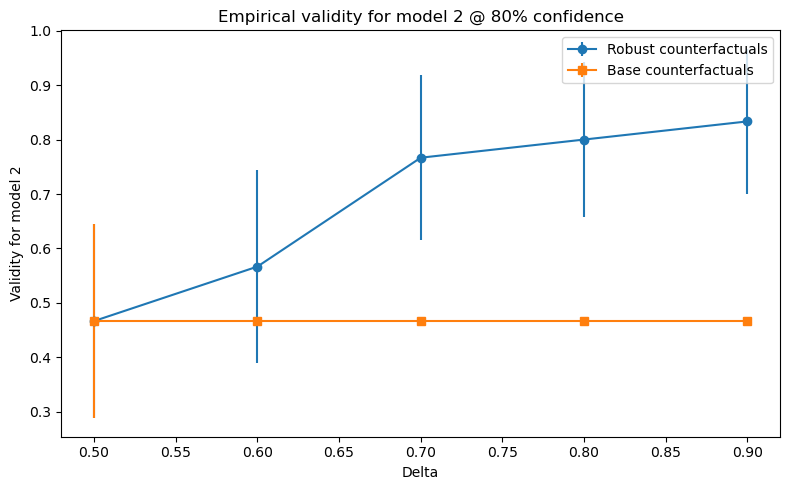

In [63]:
import numpy as np

robust = []
robust_ci = []
base = []
base_ci = []

unique_deltas = sorted(df['delta_robustness'].unique())
confidence = 0.8
z = 1.96  # z-score for 95% confidence

for delta in unique_deltas:
    robust_data = df[(df['delta_robustness'] == delta) & (df['beta_confidence'] == confidence)]['robust_counterfactual_validity_model2'].dropna()
    robust_mean = robust_data.mean()
    robust.append(robust_mean)
    robust_ci.append(z * np.sqrt((robust_mean*(1-robust_mean))/len(robust_data)))

    base_data = df[(df['delta_robustness'] == delta) & (df['beta_confidence'] == confidence)]['base_counterfactual_validity_model2'].dropna()
    base_mean = base_data.mean()
    base.append(base_mean if not pd.isna(base_mean) else base[0])
    base_ci.append(z * np.sqrt((base_mean*(1-base_mean))/len(base_data)) if not pd.isna(base_mean) else 0)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plt.title(f'Empirical validity for model 2 @ {int(confidence*100)}% confidence')
plt.xlabel('Delta')
plt.ylabel('Validity for model 2')

plt.errorbar(unique_deltas, robust, yerr=robust_ci, label='Robust counterfactuals', marker=markers[0], color=colors_discrete[0])
plt.errorbar(unique_deltas, base, yerr=base_ci, label='Base counterfactuals', marker=markers[1], color=colors_discrete[1])

plt.legend()
plt.tight_layout()

plt.show()